# Aqora Clinical Trial Optimization Problem
## Introduction
The Aqora clinical trial optimization problem seeks development towards consistent robust outcomes in clinical trials. By doing this it seeks to maximize efficency, minimize costs and ensure statistically valid results. Clinical trials are necessary for testing safety and efficacy of novel drugs, however given the low rate of success, and high cost of drug development and running the trial, minimizing disturbances within the dataset is critical. Minimizing disturbances between groups is possible via computational optimization, which allows for factors characterizing the patients to be compared and the patients placed into groups to minimize the discrepency between the two groups. 

Each patient is associated with 3 covariates corresponding to their age, Alkaline Phosphate and Prothrombin time. In this example these values are defined as

 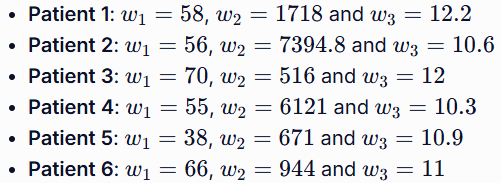

similarly the solution array is presented as 

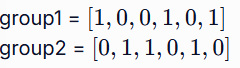

These values can be input into the following formulas to calculate the discrepency, in theory by utilizing the solution set and covariates it should be possible to calculate the aqora given discrepency of 1.485

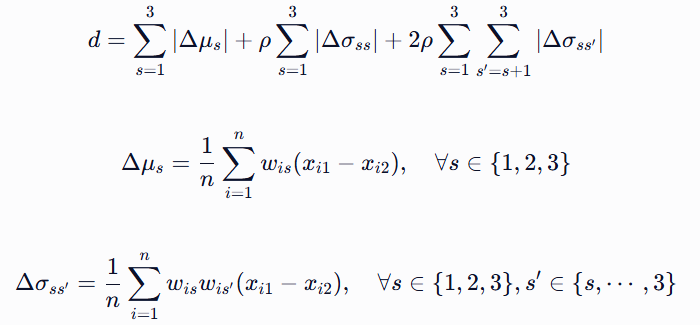

## Calculations by Hand
Delta Mu can be calculated by 1/n times the sum from i to n of w, each covariate, multiplied by xi1-xi2 which indicates the group that the patient connected to the covariate is in. By multiplying each covariate by the corresponding group then summing each of the patients then dividing by the number of patients, delta_mu can be found.

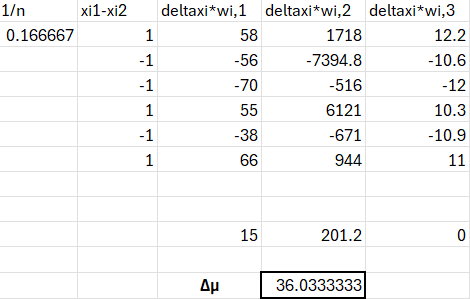

Similarly, delta_sigma_ss can be calculated by squaring each of the covariates then multiplying by a negative or a positive one correlating to the corresponding groups. Each of these rows are then summed together, divided by n, and absolute valued to find the resulting delta sigma_ss

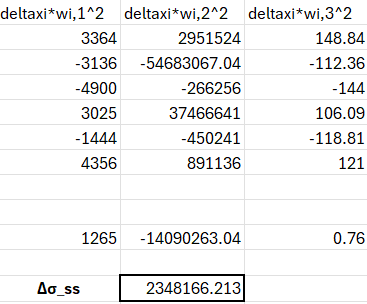

delta sigma_ss' is a little more complex however, given that the covariates differ based on the value of s. given that s' is s+1 and s can never be greater than s' this leaves us with the combinations of 12, 13 and 23. By multiplying the corresponding covariates then the overall values by their group (positive or negative), then summing all of these values, delta_sigma_ss' can be calculated.

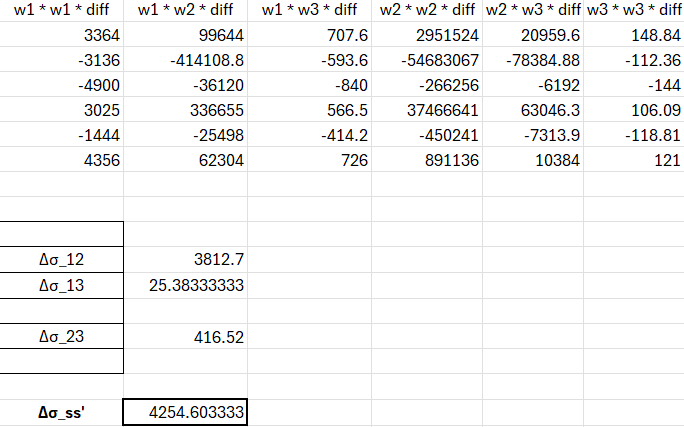

By multiplying delta sigma_ss by a value of .5 to account for rho, then summing it with delta sigma_ss' and delta mu we find the final discrepency value of 1178373.74

# Code

While calculation by hand is great for a proof of concept, being able to implement it into a code that can scale to a variety of inputs is necessary to convert from a purely academic problem to a real world solution. In order to make the code optimization friendly, elements such as absolute values must be rebuilt as constraints. Similarly, aqora outlines additional constraints necessary to setup the project

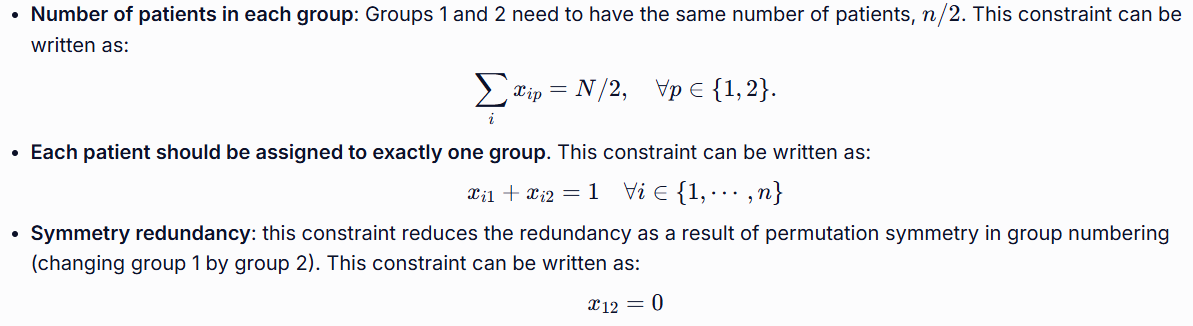

In [ ]:
from pyomo.environ import *

# Create an optimization model called clinical trial
model = ConcreteModel(name="clinical trial")

# Add a set of covariates that goes from 1 to 3
model.covariates = Set(initialize=[1, 2, 3])

# Add a set of patients that goes from 1 to n_patients (initially 6)
model.patients = Set(initialize=[1, 2, 3, 4, 5, 6])

# Add a set of groups to assign the patients to
model.groups = Set(initialize=[1, 2])

# Add a parameter w for each covariate and each patient
model.w = Param(model.covariates,
                model.patients,
                initialize={
                    (1, 1): 58, (1, 2): 56, (1, 3): 70, (1, 4): 55, (1, 5): 38, (1, 6): 66,
                    (2, 1): 1718, (2, 2): 7394.8, (2, 3): 516, (2, 4): 6121, (2, 5): 671, (2, 6): 944,
                    (3, 1): 12.2, (3, 2): 10.6, (3, 3): 12, (3, 4): 10.3, (3, 5): 10.9, (3, 6): 11})

# Add a parameter rho that is equal to 0.5
model.rho = Param(initialize=0.5)

# Add a binary variable that assigns each patient to each group
model.x = Var(model.patients, model.groups, within=Binary)

# Add a constraint that says that each patient can only be assigned to one group
def one_group_rule(model, i):
    return sum(model.x[i, j] for j in model.groups) == 1
model.one_group = Constraint(model.patients, rule=one_group_rule)

# Add a constraint that says that the first patient needs to be assigned to the first group
def first_patient_rule(model):
    return model.x[1, 1] == 1
model.first_patient = Constraint(rule=first_patient_rule)

# Add a constraint that says that each group has to have num_patients / 2
def num_patients_rule(model, j):
    return sum(model.x[i, j] for i in model.patients) == len(model.patients) / 2
model.num_patients = Constraint(model.groups, rule=num_patients_rule)

The above code defines the constraints necessary to characterize the problem for the case of a clinical trial with 2 groups. It also defines all of the covariates, which in this case are hardcoded. In a future revesion it would be ideal to input a csv file with all of the covariates and output a list of individuals belonging to each group.

In [ ]:
# Define continuous variables delta_mu, delta_sigma_mod, and delta_sigma for each covariate
model.delta_mu = Var(model.covariates, within=Reals)

# Define variable sigma for every pair of 2 covariates
model.delta_sigma = Var(model.covariates, model.covariates, within=Reals)

# Only consider upper triangular combinations of covariates for delta_sigma
def delta_sigma_rule(model, s, s_prime):
    # If s_prime is smaller than s, skip the constraint
    if s_prime < s:
        return Constraint.Skip
    # Otherwise, enforce that delta_sigma[s, s_prime] is equal 1/n_patients(sum of w_i_s * w_i_s_prime times the difference of x_i_1 and x_i_2)
    return model.delta_sigma[s, s_prime] == sum(model.w[s, i] * model.w[s_prime, i] * (model.x[i, 1] - model.x[i, 2]) for i in model.patients) / len(model.patients)

model.delta_sigma_constraint = Constraint(model.covariates, model.covariates, rule=delta_sigma_rule)

# Add constraint that calculates delta_mu
def delta_mu_rule(model, s):
    return model.delta_mu[s] == sum(model.w[s, i] * (model.x[i, 1] - model.x[i, 2]) for i in model.patients) / len(model.patients)
model.delta_mu_constraint = Constraint(model.covariates, rule=delta_mu_rule)

The above code defines the variables utilized in the final optimization model according to their definitions. Note how for delta sigma_ss', an upper triangular matrix is utilized to exclude all values that don't fit the constraint that s prime must be greater than s in that case.

In [ ]:
# Add variable for absolute value of delta_mu
model.delta_mu_abs = Var(model.covariates, within=NonNegativeReals)

# Add constraint that calculates the absolute value of delta_mu
def delta_mu_abs_rule1(model, s):
    return model.delta_mu[s] <= model.delta_mu_abs[s]
model.delta_mu_abs_constraint1 = Constraint(model.covariates, rule=delta_mu_abs_rule1)

def delta_mu_abs_rule2(model, s):
    return -model.delta_mu[s] <= model.delta_mu_abs[s]
model.delta_mu_abs_constraint2 = Constraint(model.covariates, rule=delta_mu_abs_rule2)

# Add variable for absolute value of delta_sigma
model.delta_sigma_abs = Var(model.covariates, model.covariates, within=NonNegativeReals)

# Add constraint that calculates the absolute value of delta_sigma
def delta_sigma_abs_rule1(model, s, s_prime):
    return model.delta_sigma[s, s_prime] <= model.delta_sigma_abs[s, s_prime]
model.delta_sigma_abs_constraint1 = Constraint(model.covariates, model.covariates, rule=delta_sigma_abs_rule1)

def delta_sigma_abs_rule2(model, s, s_prime):
    return -model.delta_sigma[s, s_prime] <= model.delta_sigma_abs[s, s_prime]
model.delta_sigma_abs_constraint2 = Constraint(model.covariates, model.covariates, rule=delta_sigma_abs_rule2)

In [ ]:
Above is the set of code that builds the absolute value structure for each variable in the final model. By setting an absolute value version of each variable as
greater than or equal to the original version of the variable and the original times -1, the positive version of the variable can always be sourced in the defined
variable_abs.

In [ ]:
def objective_rule(model):
    return sum(model.delta_mu_abs[s] for s in model.covariates) + model.rho * sum(model.delta_sigma_abs[s,s] for s in model.covariates) + 2 * model.rho * sum(sum(model.delta_sigma_abs[s, s_prime] for s_prime in model.covariates if s_prime > s) for s in model.covariates)
model.objective = Objective(rule=objective_rule, sense=minimize)

Finally we can add the absolute values of the model variables into the final model, multiplied by rho and send that to Gurobi for optimization (defined below), which will return the optimization results from the problem and print them in the console.

In [ ]:
# Create a solver (use Gurobi)
solver = SolverFactory('gurobi')

# Solve the model
solver.solve(model)

model.pprint()

# Print the results
for i in model.covariates:
    print(f"delta_mu_abs_{i} = {model.delta_mu_abs[i].value}")
    for j in model.covariates:
        print(f"delta_sigma_abs_{i}_{j} = {model.delta_sigma_abs[i, j].value}")
for i in model.patients:
    for j in model.groups:
        print(f"x_{i}_{j} = {model.x[i, j].value}")
print(f"Objective = {model.objective()}")

The output of this code is seen below. It can be noted that the discrepency doesn't line up with aqora's, largely due to the large delta sigma_ss_2 which is around 14 million prior to normalization. 

delta_mu_abs_1 = 2.5
delta_sigma_abs_1_1 = 210.83333333333334
delta_sigma_abs_1_2 = 3812.7
delta_sigma_abs_1_3 = 25.383333333333333
delta_mu_abs_2 = 33.53333333333333
delta_sigma_abs_2_1 = 0.0
delta_sigma_abs_2_2 = 2348377.1733332253
delta_sigma_abs_2_3 = 416.51999999993484
delta_mu_abs_3 = 0.0
delta_sigma_abs_3_1 = 0.0
delta_sigma_abs_3_2 = 0.0
delta_sigma_abs_3_3 = 0.12666666666666668
x_1_1 = 1.0
x_1_2 = 0.0
x_2_1 = 0.0
x_2_2 = 1.0
x_3_1 = 0.0
x_3_2 = 1.0
x_4_1 = 1.0
x_4_2 = 0.0
x_5_1 = 0.0
x_5_2 = 1.0
x_6_1 = 1.0
x_6_2 = 0.0
Objective = 1178584.7033332794